In [6]:
import os
os.chdir('/home/jknize/main/repo/CSC578/detectron2')

Simple ResNet object detection evaluation using pre-trained backbone

In [ ]:
# from detectron2.structures import BoxMode

# # DatasetCatalog.remove("sub_trn")
# # MetadataCatalog.remove("sub_trn")
# def get_sub_dicts(img_dir):
#     json_file =  "../datasets/coco/annotations/filtered_instances_train2017.json"
#     with open(json_file) as f:
#         imgs_anns = json.load(f)

#     dataset_dicts = []
#     for idx, v in enumerate(imgs_anns.values()):
#         record = {}
        
#         filename = os.path.join(img_dir, v["filename"])
#         height, width = cv2.imread(filename).shape[:2]
        
#         record["file_name"] = filename
#         record["image_id"] = idx
#         record["height"] = height
#         record["width"] = width
      
#         annos = v["regions"]
#         objs = []
#         for _, anno in annos.items():
#             assert not anno["region_attributes"]
#             anno = anno["shape_attributes"]
#             px = anno["all_points_x"]
#             py = anno["all_points_y"]
#             poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
#             poly = [p for x in poly for p in x]

#             obj = {
#                 "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
#                 "bbox_mode": BoxMode.XYXY_ABS,
#                 "segmentation": [poly],
#                 "category_id": 0,
#             }
#             objs.append(obj)
#         record["annotations"] = objs
#         dataset_dicts.append(record)
#     return dataset_dicts

# DatasetCatalog.register("sub_trn", lambda d=d: get_sub_dicts("../datasets/coco_cls"))
# MetadataCatalog.get("sub_trn").set(thing_classes=["person", "dog", "bottle", "chair", "book"])
# sub_metadata = MetadataCatalog.get("sub_trn")

Create dataset

In [41]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_val_dataset", {}, "../datasets/coco/annotations/filtered_instances_val2017.json", "../datasets/coco/val2017")

Check that dataset loaded correctly by sampling 3 random images


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



../datasets/coco/val2017/000000569059.jpg


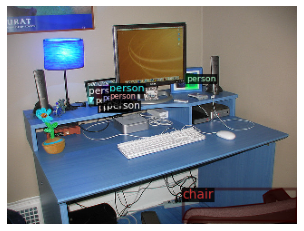

../datasets/coco/val2017/000000179898.jpg


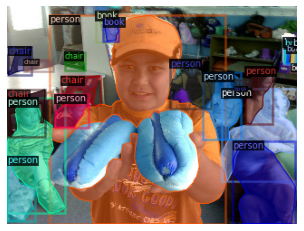

../datasets/coco/val2017/000000132587.jpg


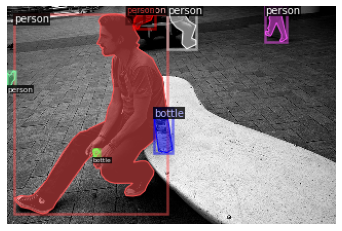

In [ ]:
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer
import random
import cv2
import matplotlib.pyplot as plt

my_dataset_metadata = MetadataCatalog.get("my_val_dataset")
dataset_dicts = DatasetCatalog.get("my_val_dataset")

# Visualize 3 random images
for d in random.sample(dataset_dicts, 3):
    file_name = d['file_name']
    img = cv2.imread(d["file_name"]) 
    if img is None:
        print(f"Failed to load image: {d['file_name']}")
        continue 
     
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)  # Draw annotations on the image
    output_image = out.get_image()[:, :, ::-1]  # Convert back from BGR to RGB for matplotlib
    plt.imshow(output_image)
    plt.axis("off")  # Turn off axis
    plt.show()

In [ ]:
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# load simple ResNet-50 model without FPN
cfg = get_cfg()
# cfg.merge_from_file("configs/COCO-Detection/faster_rcnn_R_50_C4_1x.yaml")
# cfg.merge_from_file("configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml.yaml")
# # use COCO-pretrained detection weights for quick evaluation
# # cfg.MODEL.WEIGHTS = "detectron2://COCO-Detection/faster_rcnn_R_50_C4_1x/137849393/model_final_721ade.pkl"
# # cfg.MODEL.WEIGHTS = "detectron2://ImageNetPretrained/MSRA/R-50.pkl"
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
# cfg.DATASETS.TEST = ("my_val_dataset",)
cfg.merge_from_file(model_zoo.get_config_file("configs/COCOInstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("configs/COCOInstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("my_val_dataset", cfg, False, output_dir="./knize/output")
val_loader = build_detection_test_loader(cfg, "my_val_dataset")

metrics = inference_on_dataset(DefaultTrainer.build_model(cfg), val_loader, evaluator)
print("Evaluation Results:", metrics)

R-50.pkl: 102MB [00:00, 106MB/s]                             
Some model parameters or buffers are not found in the checkpoint:
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
The checkpoint state_dict contains keys that are not used by the model:
  fc1000.{bias, weight}
  stem.conv1.bias


In [50]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("my_val_dataset", output_dir="./knize/output")
val_loader = build_detection_test_loader(cfg, "my_val_dataset")
print(inference_on_dataset(predictor.model, val_loader, evaluator))


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

/home/jknize/.local/lib/python3.8/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


KeyboardInterrupt: 